<a href="https://colab.research.google.com/github/rahiakela/modern-computer-vision-with-pytorch/blob/main/8-advanced-object-detection/3_training_ssd_based_custom_object_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training SSD on a custom object detectors

The workings behind how SSD helps overcome the issue of detecting objects with
different scales is as follows:

- We leverage the pre-trained VGG network and extend it with a few
additional layers until we obtain a 1 x 1 block.
- Instead of leveraging only the final layer for bounding box and class
predictions, we will leverage all of the last few layers to make class and
bounding box predictions.
- In place of anchor boxes, we will come up with default boxes that have a
specific set of scale and aspect ratios.
- Each of the default boxes should predict the object and bounding box offset
just like how anchor boxes are expected to predict classes and offsets in
YOLO.

In this notebook, we will learn about the working details of SSD before training it on our custom dataset.

## Setup

In [ ]:
!pip install torch_snippets

In [ ]:
from torch_snippets import *
from torchvision.ops import nms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

2021-03-01 07:12:38.404 | WARNING  | torch_snippets.torch_loader:<module>:232 - Not importing Lightning Report


## Components of modern object detection algorithms

The drawback of the R-CNN and Fast R-CNN techniques is that they have two
disjointed networks – one to identify the regions that likely contain an object and the other to make corrections to the bounding box where an object is identified. Furthermore, both the models require as many forward propagations as there are region proposals. 

Modern object detection algorithms focus heavily on training a single neural network and have the capability to detect all objects in one forward pass. In the subsequent sections, we will learn about the various components of a typical modern object detection algorithm:

- Anchor boxes
- Region proposal network (RPN)
- Region of interest pooling

### Anchor boxes

So far, we have had region proposals coming from the selectivesearch method.
Anchor boxes come in as a handy replacement for selective search.

Typically, a majority of objects have a similar shape – for example, in a majority of cases, a bounding box corresponding to an image of a person will have a greater height than width, and a bounding box corresponding to the image of a truck will have a greater width than height. 

Thus, we will have a decent idea of the height and width of the objects present in an image even before training the model (by inspecting the ground truths of bounding boxes corresponding to objects of various classes).

Furthermore, in some images, the objects of interest might be scaled – resulting in a much smaller or much greater height and width than average – while still maintaining the aspect ratio.

Once we have a decent idea of the aspect ratio and the height and width of objects
(which can be obtained from ground truth values in the dataset) present in our
images, we define the anchor boxes with heights and widths representing the
majority of objects' bounding boxes within our dataset.

Typically, this is obtained by employing K-means clustering on top of the ground
truth bounding boxes of objects present in images.

Now that we understand how anchor boxes' heights and widths are obtained, we will learn about how to leverage them in the process:

1. Slide each anchor box over an image from top left to bottom right.
2. The anchor box that has a high intersection over union (IoU) with the
object will have a label that mentions that it contains an object, and the
others will be labeled 0:
  - We can modify the threshold of the IoU by mentioning that if the IoU
is greater than a certain threshold, the object class is 1; if it is less than
another threshold, the object class is 0, and it is unknown otherwise.

Once we obtain the ground truths as defined here, we can build a model that can
predict the location of an object and also the offset corresponding to the anchor box to match it with ground truth.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/anchors-box.png?raw=1' width='800'/>

In the preceding image, we have two anchor boxes, one that has a greater height than width and the other with a greater width than height, to correspond to the objects(classes) in the image – a person and a car.

We slide the two anchor boxes over the image and note the locations where the IoU of the anchor box with the ground truth is the highest and denote that this particular location contains an object while the rest of the locations do not contain an object.

In addition to the preceding two anchor boxes, we would also create anchor boxes
with varying scales so that we accommodate the differing scales at which an object can be presented within an image.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/aspect-ratio.png?raw=1' width='800'/>

Note that all the anchor boxes have the same center but different aspect ratios or scales.

### Region Proposal Network

Imagine a scenario where we have a 224 x 224 x 3 image. Furthermore, let's say that the anchor box is of shape 8 x 8 for this example. If we have a stride of 8 pixels, we are fetching 224/8 = 28 crops of a picture for every row – essentially 28*28 = 576 crops from a picture. 

We then take each of these crops and pass through a Region Proposal
Network model (RPN) that indicates whether the crop contains an image. Essentially, an RPN suggests the likelihood of a crop containing an object.

Let's compare the output of selectivesearch and the output of an RPN.

selectivesearch gives a region candidates based on a set of computations on top
of pixel values. However, an RPN generates region candidates based on the anchor
boxes and the strides with which anchor boxes are slid over the image. Once we
obtain the region candidates using either of these two methods, we identify the
candidates that are most likely to contain an object.

While region proposal generation based on selectivesearch is done outside of the
neural network, we can build an RPN that is a part of the object detection network. Using an RPN, we are now in a position where we don't have to perform unnecessary computations to calculate region proposals outside of the network. This way, we have a single model to identify regions, identify classes of objects in image, and identify their corresponding bounding box locations.

Next, we will learn how an RPN identifies whether a region candidate (a crop
obtained after sliding an anchor box) contains an object or not. In our training data, we would have the ground truth correspond to objects. We now take each region candidate and compare with the ground truth bounding boxes of objects in an image to identify whether the IoU between a region candidate and a ground truth bounding box is greater than a certain threshold.

If the IoU is greater than a certain threshold (say, 0.5), the region candidate contains an object, and if the IoU is less than a threshold (say 0.1), the region candidate does not contain an object and all the candidates that have an IoU between the two thresholds (0.1 - 0.5) are ignored while training.

Once we train a model to predict if the region candidate contains an object, we then perform non-max suppression, as multiple overlapping regions can contain an object.

In summary, an RPN trains a model to enable it to identify region proposals with a high likelihood of containing an object by performing the following steps:

1. Slide anchor boxes of different aspect ratios and sizes across the image to
fetch crops of an image.
2. Calculate the IoU between the ground truth bounding boxes of objects in
the image and the crops obtained in the previous step.
3. Prepare the training dataset in such a way that crops with an IoU greater
than a threshold contain an object and crops with an IoU less than a
threshold do not contain an object.
4. Train the model to identify regions that contain an object.
5. Perform non-max suppression to identify the region candidate that has the
highest probability of containing an object and eliminate other region
candidates that have a high overlap with it.

### Classification and regression

So far, we have learned about the following steps in order to identify objects and perform offsets to bounding boxes:

1. Identify the regions that contain objects.
2. Ensure that all the feature maps of regions, irrespective of the regions'
shape, are exactly the same using region of interest (RoI) pooling

Two issues with these steps are as follows:

1. The region proposals do not correspond tightly over the object (IoU>0.5 is
the threshold we had in the RPN).
2. We identified whether the region contains an object or not, but not the class
of the object located in the region.

We address these two issues in this section, where we take the uniformly shaped
feature map obtained previously and pass it through a network. We expect the
network to predict the class of the object contained within the region and also the offsets corresponding to the region to ensure that the bounding box is as tight as possible around the object in the image.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/classification-and-regression.png?raw=1' width='800'/>

In the preceding diagram, we are taking the output of RoI pooling as input (the `7 x 7 x 512` shape), flattening it, and connecting to a dense layer before predicting two different aspects:

1. Class of object in the region
2. Amount of offset to be done on the predicted bounding boxes of the region
to maximize the IoU with the ground truth

Hence, if there are 20 classes in the data, the output of the neural network contains a total of 25 outputs – 21 classes (including the background class) and the 4 offsets to be applied to the height, width, and two center coordinates of the bounding box.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/faster-r-cnn.png?raw=1' width='800'/>

## Implementing Faster R-CNN

In this section, we will work toward training our custom object detector using Fast RCNN. Furthermore, so as to remain succinct, we provide only the additional or the changed code in this section.

## Downloading the dataset

For the scenario of object detection, we will download the data from Kaggle that is the Google Open Images v6 dataset.

However, we will work on only those images that are of a bus or a truck to ensure that we can train images (as you will shortly notice the memory issues associated with using selectivesearch).



In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahiakela","key":"484f91b2ebc194b0bff8ab8777c1ebff"}'}

In [ ]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle
kaggle datasets download -d sixhky/open-images-bus-trucks/
unzip -qq open-images-bus-trucks.zip

kaggle.json
 97% 356M/367M [00:03<00:00, 86.1MB/s]
100% 367M/367M [00:03<00:00, 111MB/s] 


## Preparing the dataset

Now that we have downloaded the dataset, we will prepare the dataset. This involves the following steps:

1. Fetching each image and its corresponding class and bounding box values
2. Fetching the region proposals within each image, their corresponding IoU, and the delta by which the region proposal is to be corrected with respect to the ground truth
3. Assigning numeric labels for each class (where we have an additional background class (besides the bus and truck classes) where IoU with the ground truth bounding box is below a threshold)
4. Resizing each region proposal to a common size in order to pass them to a network

By the end of this exercise, we will have resized crops of region proposals, along with assigning the ground truth class to each region proposal, and calculated the offset of the region proposal in relation to the ground truth bounding box. 

Specify the location of images and read the ground truths present in the CSV file that we downloaded:

In [ ]:
IMAGE_ROOT = "images/images/"
DF_RAW = df = pd.read_csv("df.csv")
print(DF_RAW.head())

            ImageID  Source LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0  0000599864fd15b3  xclick       Bus  ...  0.512700  0.650047  0.457197
1  00006bdb1eb5cd74  xclick     Truck  ...  0.241855  0.352130  0.437343
2  00006bdb1eb5cd74  xclick     Truck  ...  0.398496  0.409774  0.295739
3  00010bf498b64bab  xclick       Bus  ...  0.493882  0.705228  0.521691
4  00013f14dd4e168f  xclick       Bus  ...  0.303940  0.999062  0.523452

[5 rows x 21 columns]


Define the indices corresponding to labels and targets:

In [ ]:
label2target = {label: target + 1 for target, label in enumerate(DF_RAW["LabelName"].unique())}
label2target["background"] = 0

target2label = {target: label for label, target in label2target.items()}
background_class = label2target["background"]
num_classes = len(label2target)
num_classes

3

In [ ]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2, 0, 1)

  return img.to(device).float()

Define a class that returns the image and its corresponding class and ground truth along with the file path of the image:

In [ ]:
class OpenImages(Dataset):
  w, h = 224, 224
  def __init__(self, df, image_dir=IMAGE_ROOT):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir + "/*")
    self.df = df
    self.image_infos = df.ImageID.unique()

  def __len__(self):
    return len(self.unique_images)

  def __getitem__(self, idx):
    # load images and masks
    image_id = self.image_infos[idx]
    img_path = find(image_id, self.files)
    img = Image.open(img_path).convert("RGB")
    img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
    data = df[df["ImageID"] == image_id]
    labels = data['LabelName'].values.tolist()
    data = data[['XMin','YMin','XMax','YMax']].values
    data[:,[0,2]] *= self.w
    data[:,[1,3]] *= self.h
    boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
    # torch FRCNN expects ground truths as a dictionary of tensors
    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
    img = preprocess_image(img)

    return img, target

  def collate_fn(self, batch):
    return tuple(zip(*batch))

  def __len__(self):
    return len(self.image_infos)

Create the training and validation dataloaders and datasets

In [ ]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [ ]:
# Create the training and validation datasets and data loaders
train_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
train_df, val_df = df[df["ImageID"].isin(train_ids)], df[df["ImageID"].isin(val_ids)]
print(len(train_df), len(val_df))

21598 2464


In [ ]:
train_ds = OpenImages(train_df)
test_ds  = OpenImages(val_df)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

## Define the model

In [ ]:
def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  input_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)

  return model

Define the functions to train and validate on a batch.

In [ ]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
  model.train()
  input, targets = inputs
  input = list(image.to(device) for image in input)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input, targets)
  loss = sum(loss for loss in losses.values())
  loss.backward()
  optimizer.step()

  return loss, losses

In [ ]:
@torch.no_grad()  # this will disable gradient computation in the function below
def validate_batch(inputs, model):
  model.train()
  """
  to obtain the losses, model needs to be in train mode only.
  Note that here we are not defining the model's forward method 
  and hence need to work per the way the model class is defined
  """
  input, targets  = inputs
  input = list(image.to(device) for image in input)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  
  optimizer.zero_grad()
  losses = model(input, targets)
  loss = sum(loss for loss in losses.values())

  return loss, losses

## Train the model

Train the model over increasing epochs:

In [ ]:
model = get_model().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

We now train the model over increasing epochs.

In [ ]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    #print(inputs.size())
    loss, losses  = train_batch(inputs, model, optimizer)
    loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg =  [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
    pos = (epoch + (ix + 1) / _n)
    log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
               trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
               trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
  
  _n = len(test_loader)
  for ix, inputs in enumerate(test_loader):
    loss, losses = validate_batch(inputs, model)
    loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
    pos = (epoch + (ix + 1) / _n)
    log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
               val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
               val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
  
  if (epoch+1) % (n_epochs // 5)==0:
    log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.185	trn_loc_loss: 0.076	trn_regr_loss: 0.083	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.008	val_loss: 0.172	val_loc_loss: 0.069	val_regr_loss: 0.079	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.009	(2969.99s - 11879.96s remaining)
EPOCH: 2.000	trn_loss: 0.155	trn_loc_loss: 0.064	trn_regr_loss: 0.074	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.007	val_loss: 0.174	val_loc_loss: 0.071	val_regr_loss: 0.080	val_objectness_loss: 0.015	val_rpn_box_reg_loss: 0.009	(5946.87s - 8920.31s remaining)
EPOCH: 3.000	trn_loss: 0.145	trn_loc_loss: 0.060	trn_regr_loss: 0.071	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.007	val_loss: 0.177	val_loc_loss: 0.072	val_regr_loss: 0.081	val_objectness_loss: 0.016	val_rpn_box_reg_loss: 0.009	(8931.04s - 5954.03s remaining)
EPOCH: 4.000	trn_loss: 0.140	trn_loc_loss: 0.057	trn_regr_loss: 0.069	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.007	val_loss: 0.186	val_loc_loss: 0.075	val_regr_loss: 0.083	val_object

Plot the variation of the various loss values over increasing epochs:

100%|██████████| 106/106 [00:00<00:00, 194.77it/s]


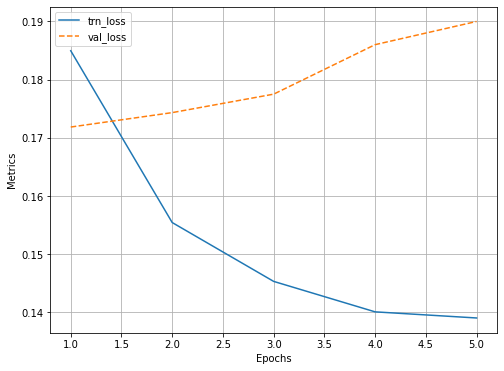

In [ ]:
# Plotting training and validation metrics
log.plot_epochs(['trn_loss','val_loss'])

### Predict on a new image

The output of the trained model contains boxes, labels, and scores
corresponding to classes. In the following code, we define a
decode_output function that takes the model's output and provides
the list of boxes, scores, and classes after non-max suppression:




In [ ]:
def decode_output(output):
  "convert tensors to numpy arrays"
  bbs = output["boxes"].cpu().detach().numpy().astype(np.uint16)
  labels = np.array([target2label[i] for i in output["labels"].cpu().detach().numpy()])
  confs = output["scores"].cpu().detach().numpy()
  ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
  bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

  if len(ixs) == 1:
      bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
  
  return bbs.tolist(), confs.tolist(), labels.tolist()

Fetch the predictions of the boxes and classes on test images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


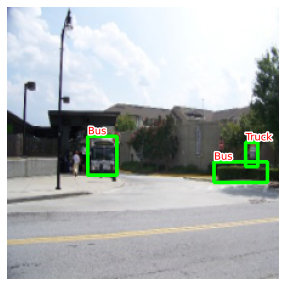

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


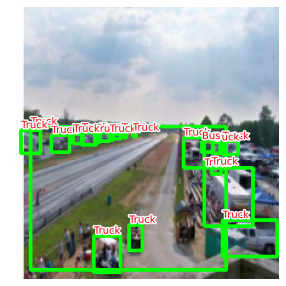

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


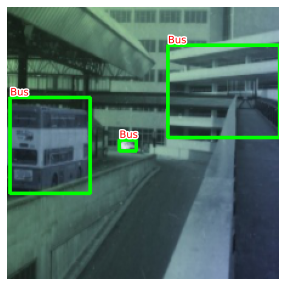

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


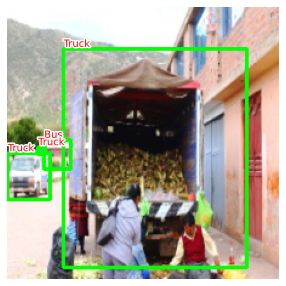

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


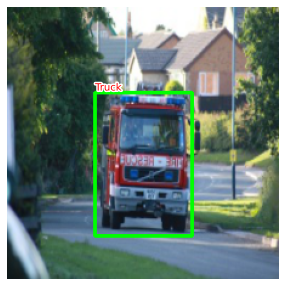

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


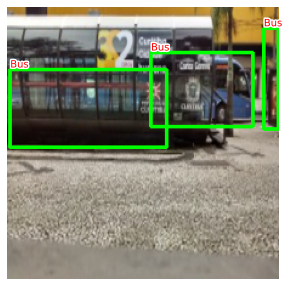

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


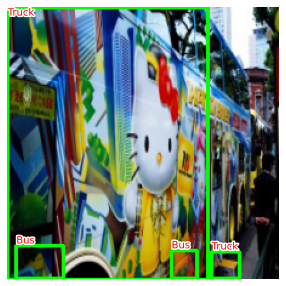

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


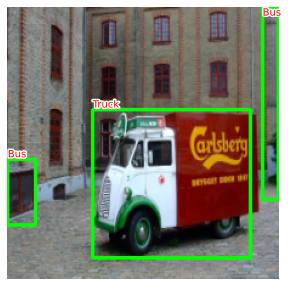

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


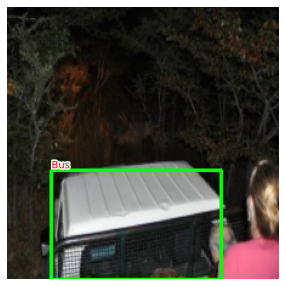

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


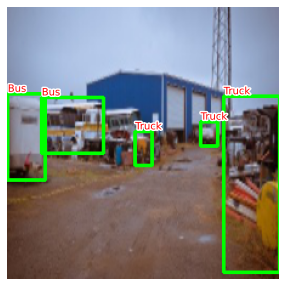

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


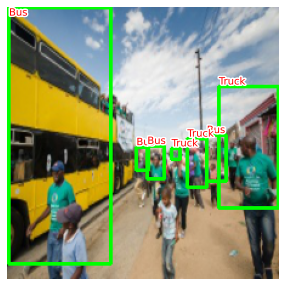

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


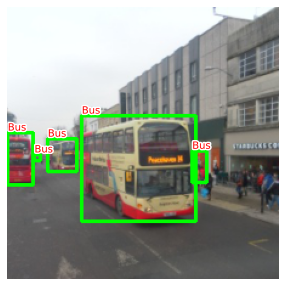

In [ ]:
model.eval()

for ix, (images, targets) in enumerate(test_loader):
  if ix == 3:
    break
  
  images = [im for im in images]
  outputs = model(images)
  for ix, output in enumerate(outputs):
    bbs, confs, labels = decode_output(output)
    info = [f"{l}@{c:.2f}" for l, c in zip(labels, confs)]
    show(images[ix].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=5)

In this notebook, we have trained a Faster R-CNN model using the
`fasterrcnn_resnet50_fpn model` class provided in the PyTorch models package.

But we should learn about **YOLO, a modern object detection algorithm that performs both object class detection and region correction in a single shot
without the need to have a separate RPN.**